## Convolutional Neural Network (CNN)

What is convolution ?

<img  src = "./fig/cnn1.png" width=250 >

It is an example of an image with  32 $*$ 32 pixels (length and width) 3 spectral bands (3 channels), 5 $*$ 5 kernel_size size [1]

The below figure shows,how exactly it works

<img src = "./fig/cnn2.png" width = 350 >

Each filter is independantly convolved with image and end up with user defined number of features. In the following figure has 6 features representation derived  from 6 filters.

<img src = "./fig/cnn3.png" width = 350 >

Where, CNN is collection of defined number of convolutional layers (blocks), convolutional (featues) result from one layer will be passed to the next layer as input as shown figure below; 

<img src = "./fig/cnn4.png" width=300 >

**Let us go to more details by making our own simple CNN using Keras**

In [20]:
import numpy as np
import keras
x_train,y_train = np.load('./dataset/isprs_vaihingen/train/patches/image.npy'),np.load('./dataset/isprs_vaihingen/train/patches/label.npy')
x_test,y_test = np.load('./dataset/isprs_vaihingen/val/patches/image.npy'),np.load('./dataset/isprs_vaihingen/val/patches/label.npy')
channel = x_train.shape[-1]
num_classes = 5
img_rows, img_cols = 256, 256
input_shape = (img_rows, img_cols, channel)
y_tra = keras.utils.to_categorical(y_train, num_classes)
y_tes = keras.utils.to_categorical(y_test, num_classes)

In [21]:
from keras.models import Sequential, Model
from keras.layers import Dense,Input,Activation,Conv2D, MaxPooling2D,UpSampling2D, Dropout,Conv2DTranspose, concatenate, Flatten,BatchNormalization

Check the **filters**, **kernel size**, **padding**,**strides**, **pooling** and number of **parameters** generated

In [22]:
model = Sequential()
model.add(Conv2D(filters = 10, kernel_size = (5,5), strides =1,padding = 'valid', 
                 input_shape=input_shape, activation='relu'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 252, 252, 10)      760       
Total params: 760
Trainable params: 760
Non-trainable params: 0
_________________________________________________________________


**What is padding**  ?

**Padding** is to add extra pixels to  outside the image to retain the original shape of the image after convolution [2]. 

<img src="./fig/no_padding_no_strides.gif" width = 250>

<img src="./fig/arbitrary_padding_no_strides.gif" width = 250>

In [23]:
model = Sequential()
model.add(Conv2D(filters = 10, kernel_size = (5,5), strides = 1, padding = 'same', 
                 input_shape=input_shape, activation='relu'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 256, 256, 10)      760       
Total params: 760
Trainable params: 760
Non-trainable params: 0
_________________________________________________________________


**Strides** is the unit of pixels which used to convolve  the kernel.

<img src="./fig/no_padding_strides.gif" width = 250>

<img src = "./fig/padding_strides.gif" width = 250>

In [24]:
model = Sequential()
model.add(Conv2D(filters = 10, kernel_size = (5,5), strides = 2, padding = 'same', 
                 input_shape=input_shape, activation='relu'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 128, 128, 10)      760       
Total params: 760
Trainable params: 760
Non-trainable params: 0
_________________________________________________________________


**Pooling layer** downsamples the volume spatially, independently in each of the input feature. This function use to reduce the spatial size and hence reduce the number of paramters and computation. Eg: maxpool, averagepool

<img src = "./fig/pooling.png" width = 350 >

In [25]:
model = Sequential()
model.add(Conv2D(filters = 10, kernel_size = (5,5), strides = 1, padding = 'same', 
                 input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 256, 256, 10)      760       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 10)      0         
Total params: 760
Trainable params: 760
Non-trainable params: 0
_________________________________________________________________


**Building Encoder-decoder CNN network in Keras**

This is CNN network consists of an encoder network, a corresponding decoder network followed by a pixel-wise classification layer.Several famous Encoder-decoder is available such as Segnet, U-net, Deconv-net etc,.

Let us define our own simple Encoder-decoder network. 

First of all define the encoder part

In [26]:
inputs = Input((input_shape))
conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

In [27]:
keras.backend.int_shape(pool2)

(None, 64, 64, 32)

Define the decoder part

In [28]:
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
up1 = UpSampling2D(size=(2, 2),interpolation='nearest')(conv3)
conv4 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D(size=(2, 2),interpolation='nearest')(conv4)
conv5 = Conv2D(num_classes, (1, 1), activation='softmax')(up2)

In [29]:
keras.backend.int_shape(conv5)

(None, 256, 256, 5)

In [30]:
model = Model(inputs=[inputs], outputs=[conv5])

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 128, 128, 32)      0         
__________

In [32]:
BATCH_SIZE= 32
EPOCHS = 2
#SGD = keras.optimizers.SGD(lr=0.01)
SGD = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
catergorical = keras.losses.categorical_crossentropy
accuracy = ['accuracy']
model.compile(loss = catergorical, optimizer = SGD,
              metrics = accuracy)

history1 = model.fit(x_train, y_tra,
                    batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data = (x_test, y_tes))

Train on 750 samples, validate on 100 samples
Epoch 1/2
750/750 [==============================] - 66s 89ms/step - loss: 1.0211 - acc: 0.5831 - val_loss: 0.8667 - val_acc: 0.6379
Epoch 2/2
750/750 [==============================] - 68s 91ms/step - loss: 0.8316 - acc: 0.6673 - val_loss: 0.8125 - val_acc: 0.6719


Load data for prediction

In [14]:
x_pred,y_pred = np.load('./dataset/isprs_vaihingen/test/patches/image.npy'),np.load('./dataset/isprs_vaihingen/test/patches/label.npy')

In [15]:
Predict_prob = model.predict(x_pred)
Predict_prob.shape
Predict_class = np.argmax(Predict_prob,axis=-1)
Predict_class.shape

(70, 256, 256)

In [16]:
y_pred.shape

(70, 256, 256)

<IPython.core.display.Javascript object>


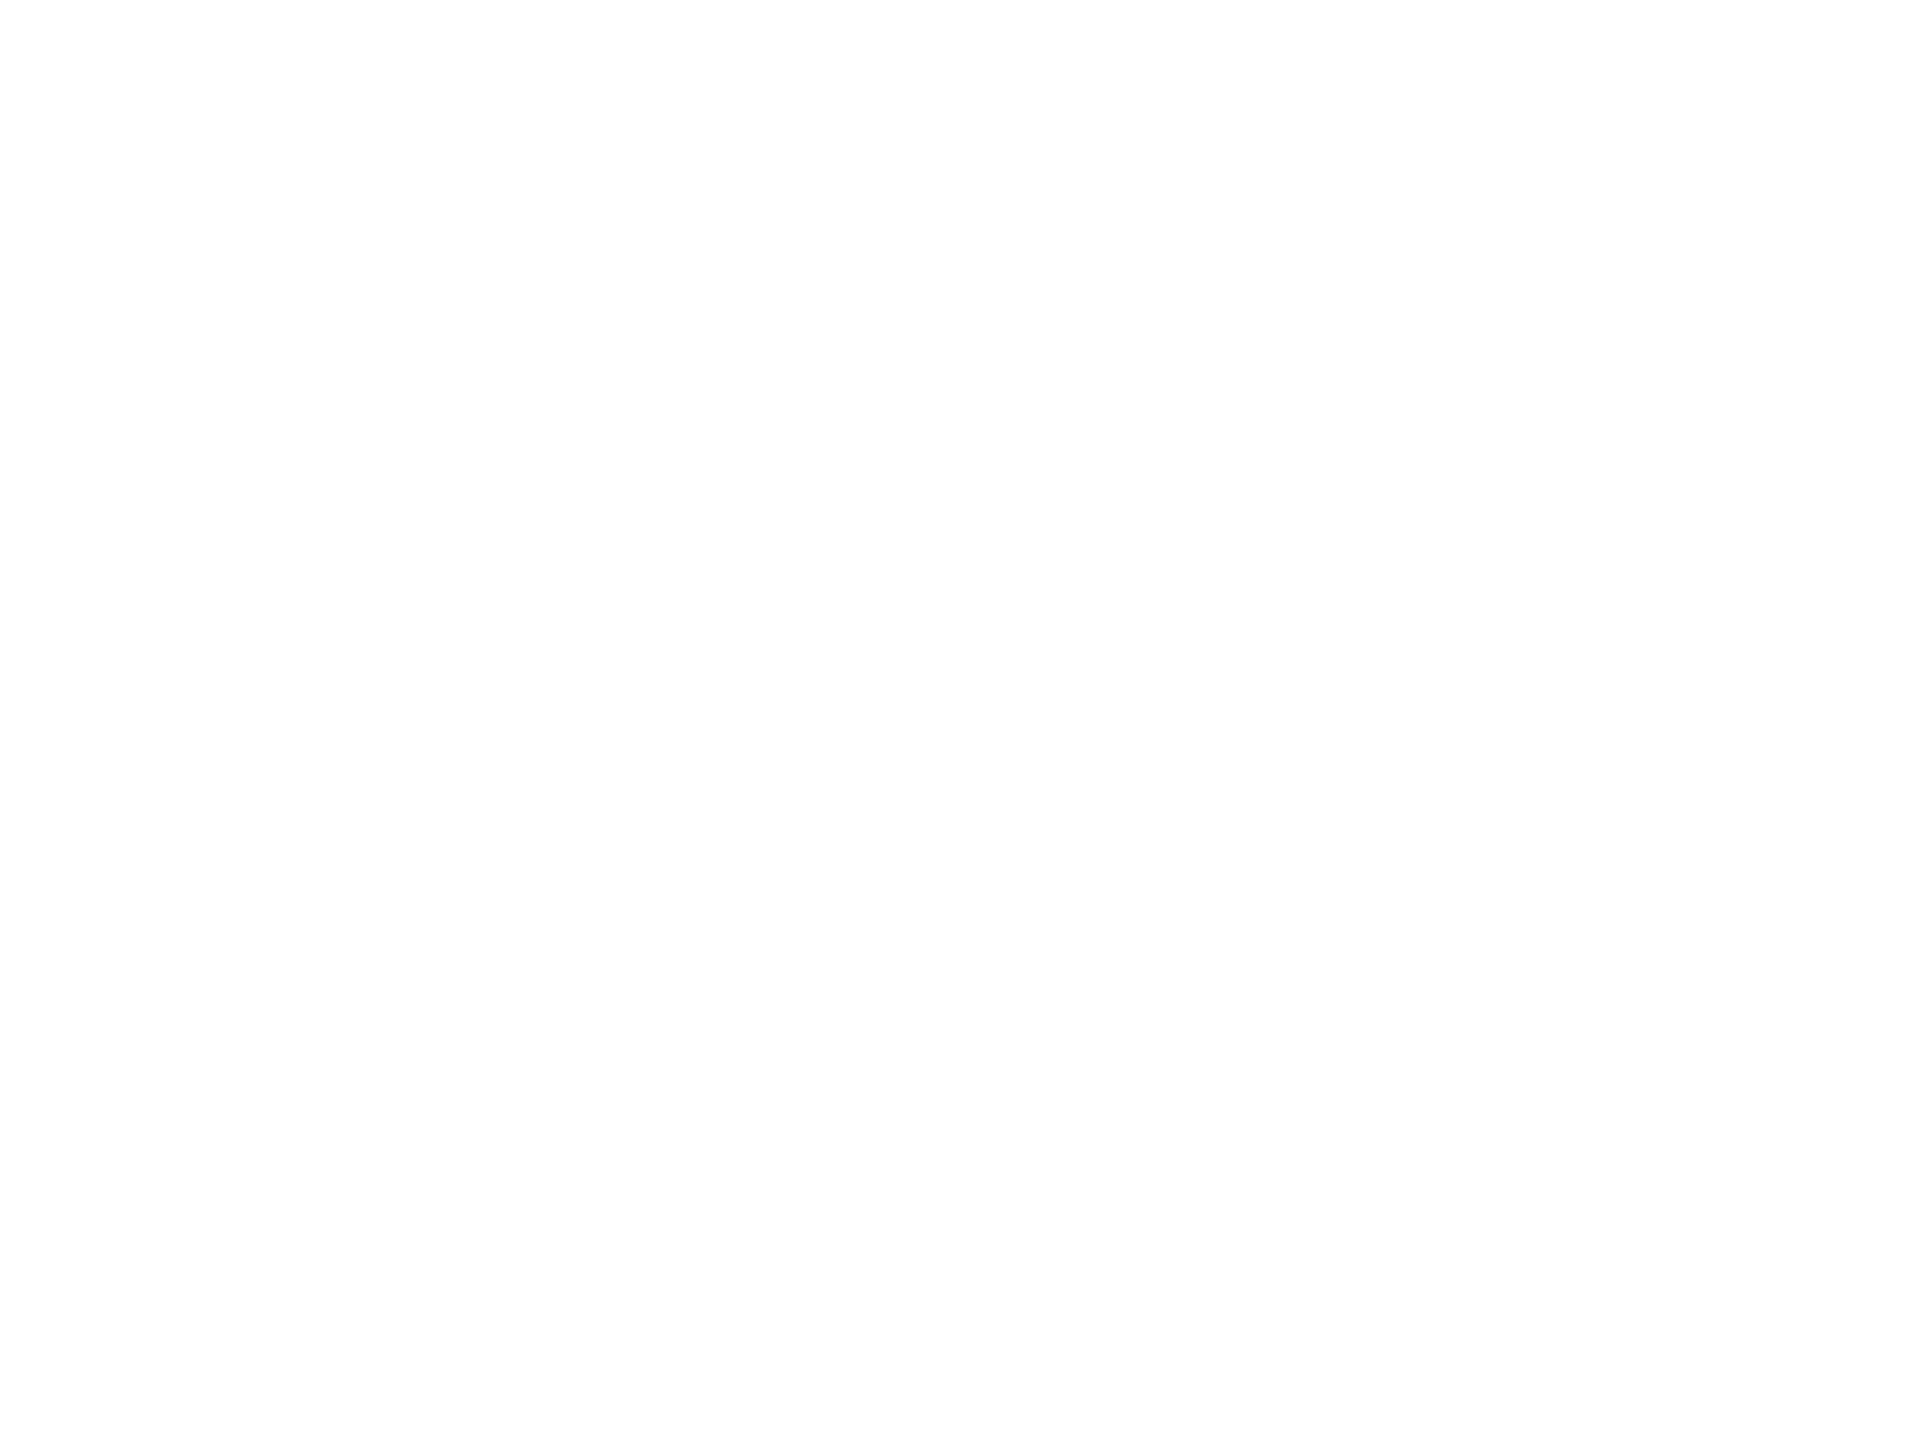

In [17]:
%matplotlib  notebook
import matplotlib.pyplot as  plt
fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(Predict_class[4], interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Predict')
fig.show()

ax = fig.add_subplot(122)
ax.imshow(y_pred[4], interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Label')

fig.suptitle('Scene: top_mosaic_09cm_area1')
fig.show()


**U-net; a deep Convolutional Networks**

U-net is an end-to-end network with U-shape. U-net consists of a contracting path (left-side) and an expansive path (right side). U-net has special architecture which concatenate lost features in the downsampling process with the appropriate features in the upsampling process. This particular aspect makes U-net as an elegant deep learning network[3].

<img src = "./fig/unet.png" width=300>

In [18]:
inputs = Input((input_shape))
# Encoder
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

# Decoder
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
conv10 = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)
model = Model(inputs=[inputs], outputs=[conv10])

In [19]:
BATCH_SIZE= 24
EPOCHS = 15
#SGD = keras.optimizers.SGD(lr=0.01)
SGD = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
catergorical = keras.losses.categorical_crossentropy
accuracy = ['accuracy']
model.compile(loss = catergorical, optimizer = SGD,
              metrics = accuracy)

history1 = model.fit(x_train, y_tra,
                    batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data = (x_test, y_tes))

Train on 750 samples, validate on 100 samples
Epoch 1/15
750/750 [==============================] - 799s 1s/step - loss: 0.8288 - acc: 0.6662 - val_loss: 1.1645 - val_acc: 0.6948
Epoch 2/15
750/750 [==============================] - 826s 1s/step - loss: 0.6309 - acc: 0.7530 - val_loss: 3.3722 - val_acc: 0.5492
Epoch 3/15
750/750 [==============================] - 889s 1s/step - loss: 0.5700 - acc: 0.7831 - val_loss: 1.7608 - val_acc: 0.7297
Epoch 4/15
192/750 [======>.......................] - ETA: 10:16 - loss: 0.5258 - acc: 0.8001

KeyboardInterrupt: 

In [28]:
from keras.models import load_model
from keras.models import model_from_json
model_json = model.to_json()
with open("./learned_weights/demo_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./learned_weights/demo_model.h5")
print("Saved model to disk")

Saved model to disk


In [29]:
Predict_prob = model.predict(x_pred)
Predict_prob.shape
Predict_class = np.argmax(Predict_prob,axis=-1)
Predict_class.shape

(70, 256, 256)

<IPython.core.display.Javascript object>


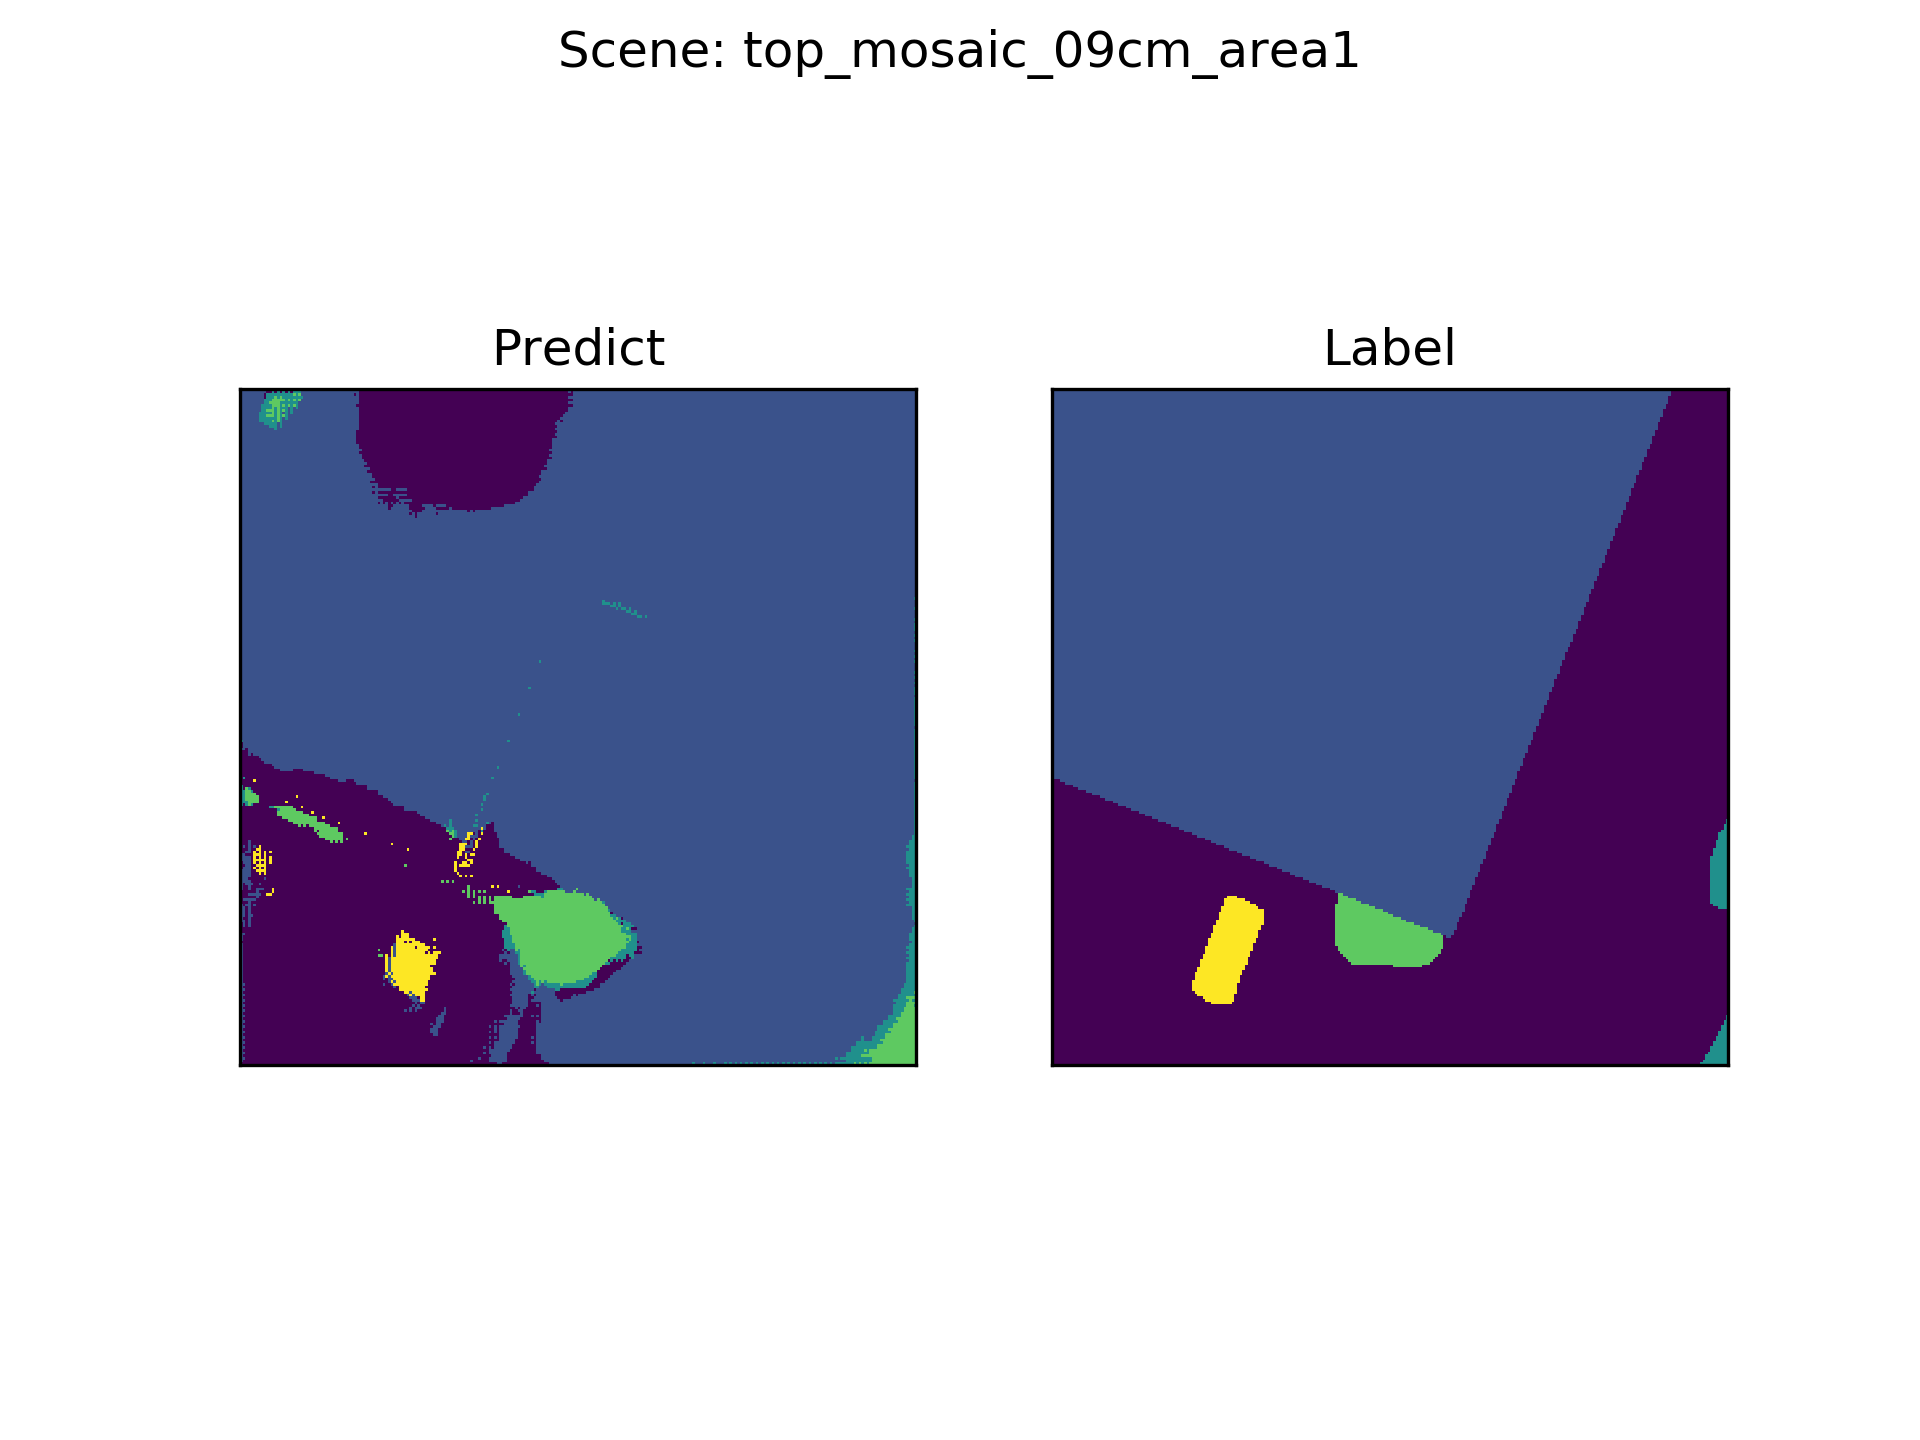

In [35]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(Predict_class[1], interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Predict')
fig.show()

ax = fig.add_subplot(122)
ax.imshow(y_pred[1], interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Label')

fig.suptitle('Scene: top_mosaic_09cm_area1')
fig.show()

In [31]:
#import h5py
json_file = open('./learned_weights/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./learned_weights/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [33]:
Predict_prob = loaded_model.predict(x_pred)
Predict_prob.shape
Predict_class = np.argmax(Predict_prob,axis=-1)
Predict_class.shape

(70, 256, 256)

In [86]:
Predict_prob = loaded_model.predict(pred)
Predict_prob.shape
Predict_class = np.argmax(Predict_prob,axis=-1)
Predict_class.shape

(300, 128, 128)

<IPython.core.display.Javascript object>


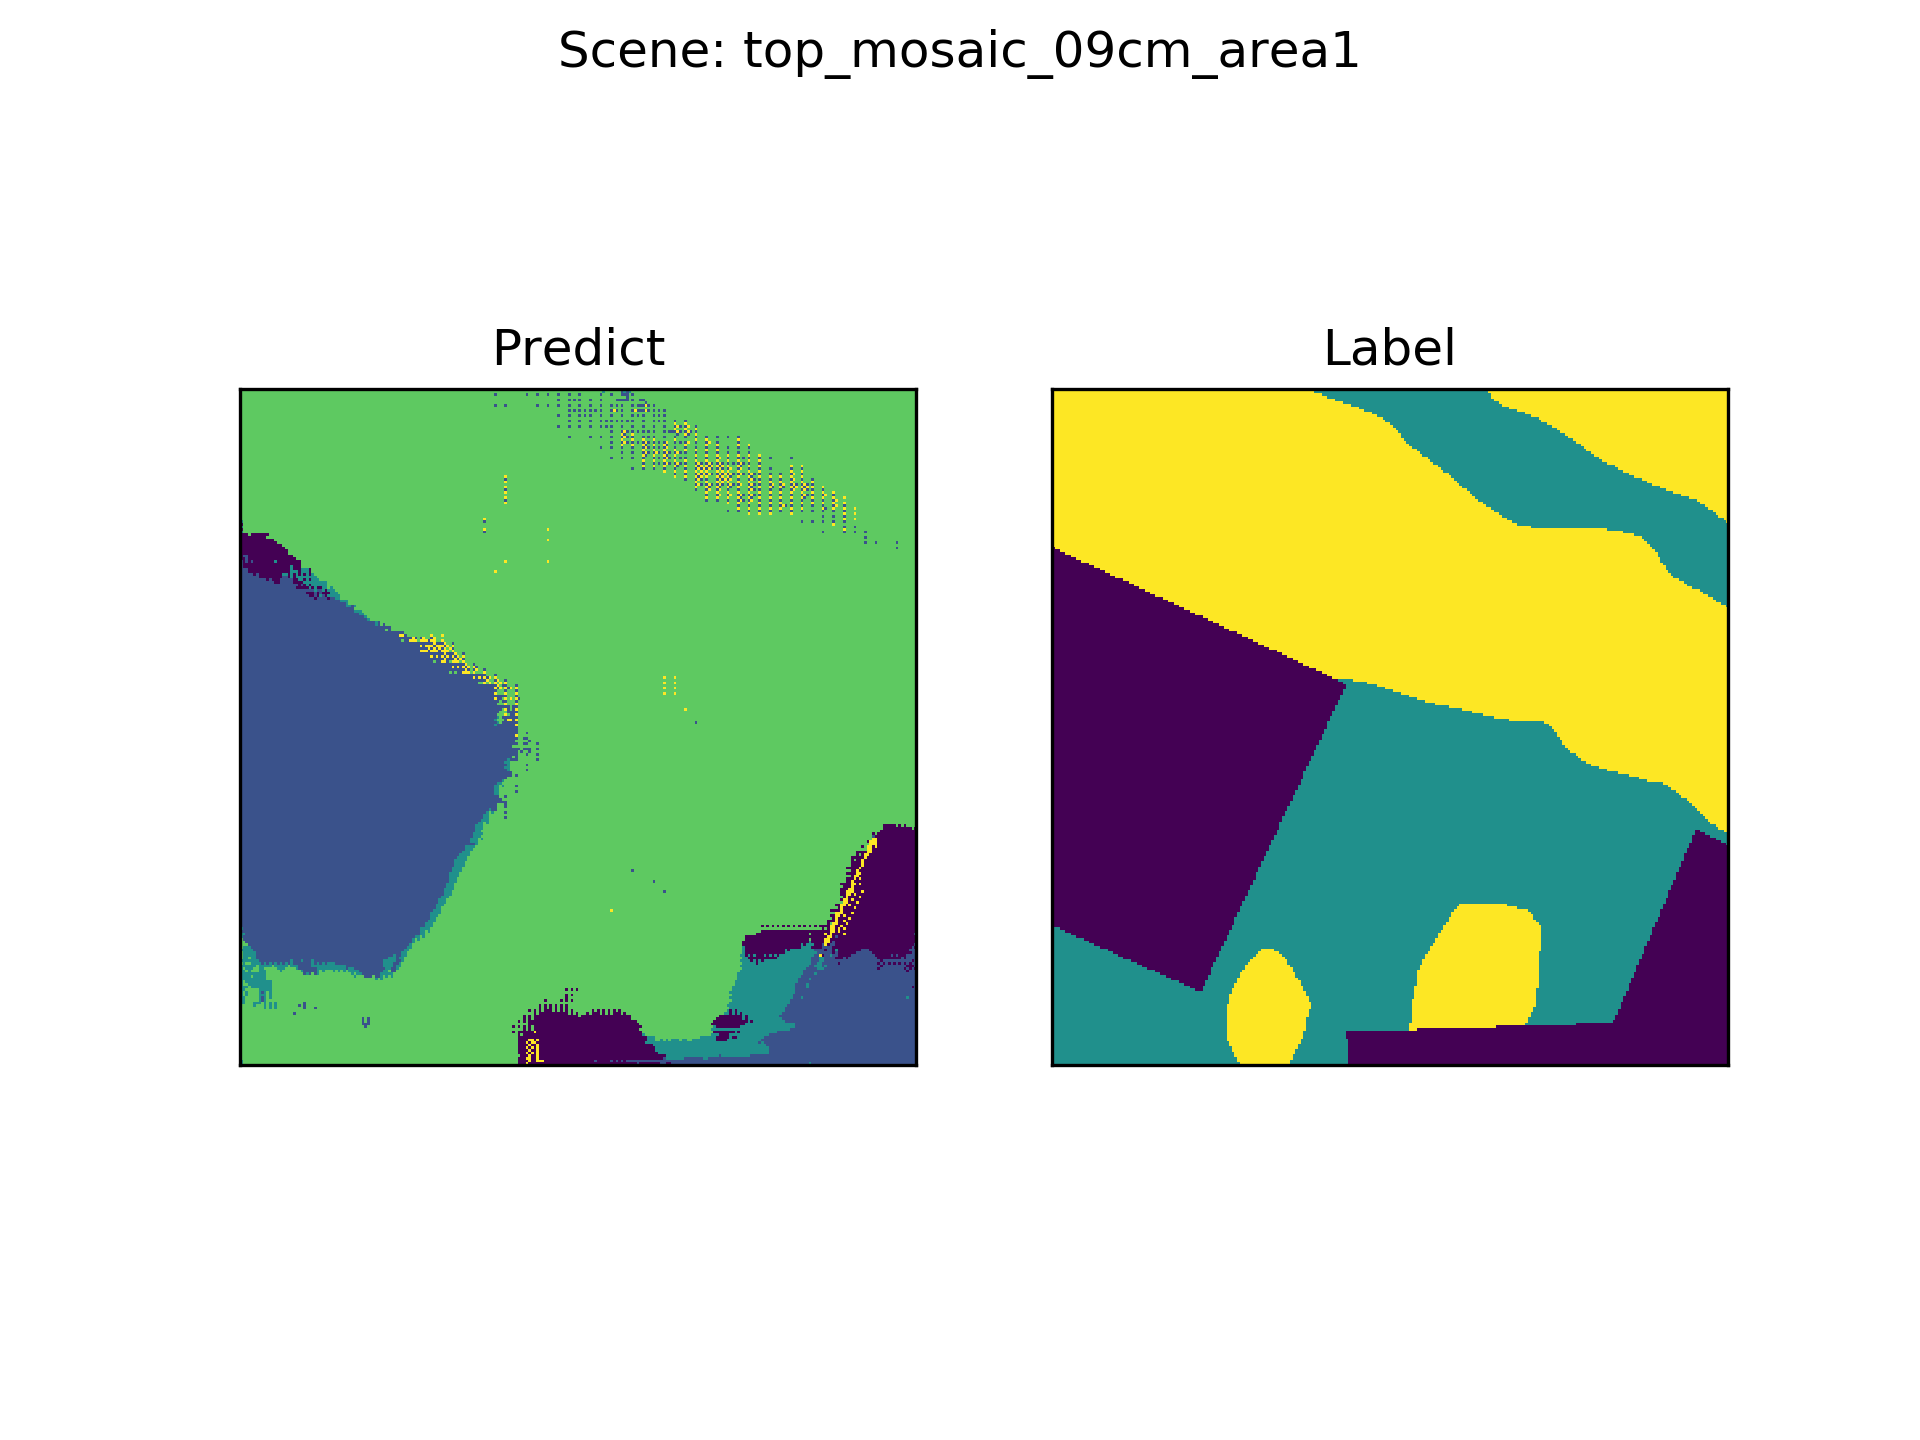

In [34]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(Predict_class[4], interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Predict')
fig.show()

ax = fig.add_subplot(122)
ax.imshow(y_pred[4], interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Label')

fig.suptitle('Scene: top_mosaic_09cm_area1')
fig.show()

**Reference**

1. Harsh Pokharna, The best explanation of Convolutional Neural Networks on the Internet
2. Vincent Dumoulin, Francesco Visin - A guide to convolution arithmetic for deep learning (BibTeX)
3. Olaf Ronneberger, Philipp Fischer, Thomas Brox, U-Net: Convolutional Networks for Biomedical Image Segmentation
